In [17]:
#!/usr/bin/env python3
import soundfile as sf
import winsound
import numpy as np
# import tensorflow as tf

In [42]:
# !pip install tensorflow==2.3.0

^C


In [5]:
block_len = 512
block_shift = 128
# load model
model = tf.saved_model.load('dtln_saved_model')
infer = model.signatures["serving_default"]

In [44]:
inputAudio = r'D:\Noise Cancellation\Experimentation\dataset\noisy_sound.wav'
audio,fs = sf.read(inputAudio)
print(fs)

16000


In [47]:
audio.shape

(160000,)

In [7]:
winsound.PlaySound(inputAudio, winsound.SND_FILENAME)

In [8]:
audio.shape

(160000,)

In [9]:
if fs != 16000:
    raise ValueError('This model only supports 16k sampling rate.')
# preallocate output audio
out_file = np.zeros((len(audio)))
# create buffer
in_buffer = np.zeros((block_len))
out_buffer = np.zeros((block_len))
# calculate number of blocks
num_blocks = (audio.shape[0] - (block_len-block_shift)) // block_shift
# iterate over the number of blcoks        
for idx in range(num_blocks):
    # shift values and write to buffer
    in_buffer[:-block_shift] = in_buffer[block_shift:]
    in_buffer[-block_shift:] = audio[idx*block_shift:(idx*block_shift)+block_shift]
    # create a batch dimension of one
    in_block = np.expand_dims(in_buffer, axis=0).astype('float32')
    # process one block
    out_block= infer(tf.constant(in_block))['conv1d_1']
    # shift values and write to buffer
    out_buffer[:-block_shift] = out_buffer[block_shift:]
    out_buffer[-block_shift:] = np.zeros((block_shift))
    out_buffer  += np.squeeze(out_block)
    # write block to output file
    out_file[idx*block_shift:(idx*block_shift)+block_shift] = out_buffer[:block_shift]
    
    
# write to .wav file 
sf.write(r'D:\Noise Cancellation\Experimentation\dataset\out.wav', out_file, fs) 

print('Processing finished.')

Processing finished.


In [1]:
import pyaudio
import numpy as np
# import pylab
import time
import sys
import matplotlib.pyplot as plt


RATE = 16000
CHUNK = int(RATE/20) # RATE / number of updates per second

def soundplot(stream):
    t1=time.time()
    data = np.fromstring(stream.read(RATE),dtype=np.int16)
    return data
#     print(data)

In [6]:
sys.maxsize**10

4455508415646675013373597242420117818453694838130159772560668808816707086990958982033203334310070688731662890013605553436739351074980172000127431349940128178077122187317837794167991459381249

In [11]:
if __name__=="__main__":
    da=[]
    p=pyaudio.PyAudio()
    stream=p.open(format=pyaudio.paInt16,channels=1,rate=RATE,input=True,
                  frames_per_buffer=CHUNK)
    for i in range(4):
        #if i%10==0: print(i) 
        print(i)
        d=soundplot(stream)
        da.append(soundplot(stream)) 
    stream.stop_stream()
    stream.close()
    p.terminate()

0


<ipython-input-1-758be9e77676>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(stream.read(RATE),dtype=np.int16)


1
2
3


In [12]:
da=np.array(da)
da.shape

(4, 16000)

In [13]:
da1 = da.reshape(-1)

In [14]:
da1.shape

(64000,)

In [15]:
import sounddevice as sd

In [16]:
sd.play(da1,16000)

In [18]:
inputAudio = r'D:\Noise Cancellation\Experimentation\dataset\traffic_sound.wav'
audio,fs = sf.read(inputAudio)
print(fs)

44100


In [19]:
audio.shape

(2919464, 2)

In [20]:
import matplotlib.pyplot as plt

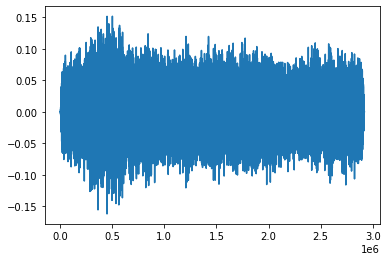

In [22]:
plt.plot(audio[:,0])

In [25]:
import librosa

In [24]:
!pip install librosa

^C


In [26]:
y, s = librosa.load(inputAudio, sr=16000) # Downsample 44.1kHz to 8kHz

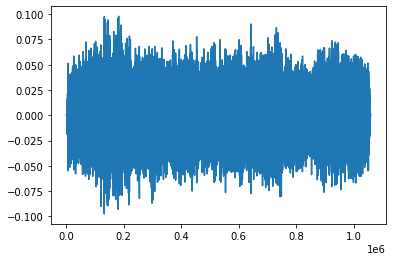

In [28]:
plt.plot(y)

In [41]:
sd.play(y[:len(da1)],16000)

In [32]:
sd.stop()

In [33]:
y.shape

(1059216,)

In [34]:
da1.shape

(64000,)

In [45]:
noisy_sound = da1 + y[:len(da1)]
noisy_sound.shape

(64000,)

In [38]:
sd.play(noisy_sound,16000)

In [ ]:
sd.stop()

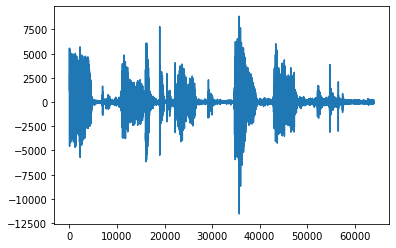

In [42]:
plt.plot(da1)

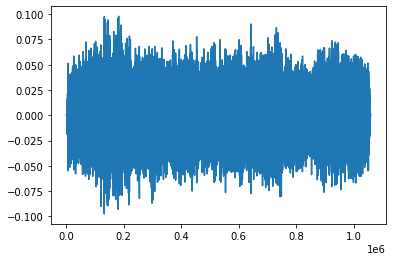

In [43]:
plt.plot(y)

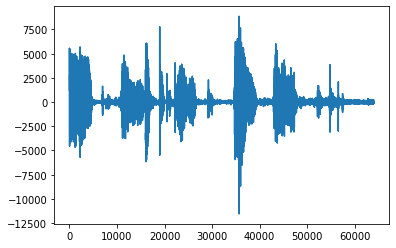

In [46]:
plt.plot(noisy_sound)

In [47]:
sf.write(r'D:\Noise Cancellation\Experimentation\dataset\out.wav', noisy_sound, 16000) 

y \--> noise\\
da1 \---> actual sound

In [48]:
y.min(),y.max()

(-0.097506896, 0.097912826)

In [49]:
da1.min(),da1.max()

(-11552, 8866)

In [53]:
cleanAudio = np.interp(da1, (da1.min(), da1.max()), (-1, 1))
noiseAudio = np.interp(y, (y.min(), y.max()), (-1, 1))

In [54]:
if(len(noiseAudio)>len(cleanAudio)):
    noiseAudio=noiseAudio[0:len(cleanAudio)]

In [55]:
noiseAudio.shape,cleanAudio.shape

((64000,), (64000,))

In [58]:
import math
def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

In [59]:
noiseAudio=get_noise_from_sound(cleanAudio,noiseAudio,SNR=10)

In [60]:
sd.play(noiseAudio,16000)

In [61]:
mixedAudio=cleanAudio+noiseAudio

In [62]:
print("SNR = " + str(20*np.log10(math.sqrt(np.mean(cleanAudio**2))/math.sqrt(np.mean(noiseAudio**2)))))

SNR = 9.999999999999998


In [63]:
sd.play(mixedAudio,16000)